# This is a Jupyter Notebook for the Applied Data Science Capstone Project

In [233]:
import pandas as pd
import numpy as np

# Segmenting and Clustering Neighborhoods in Toronto

## Part 1: Web Scraping

In [235]:
from bs4 import BeautifulSoup
import requests
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [236]:
# Reading in Data
df = pd.read_html(url)[0]
df = df.loc[(df.Borough != 'Not assigned')]

In [237]:
# Altering Neighbourhood to equal Borough if not assigned
def myfunc(x,y):
    if x == 'Not assigned' and y != 'Not assigned':
        return y
    else:
        return x

df['Neighbourhood'] = df.apply(lambda x: myfunc(x.Neighbourhood, x.Borough), axis=1)    

In [238]:
# Getting all like Neighbourhood and postal codes to align
unique = df['Postcode'].unique()
neighbourhood = np.zeros(len(unique))
borough = np.zeros(len(unique))   

In [239]:
df2 = pd.DataFrame(df.groupby(['Postcode','Borough'])['Neighbourhood'].agg(', '.join)).reset_index()
df2.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [240]:
df2.shape

(103, 3)

## Part 2: Locations

In [241]:
# Reading in provided csv
locations = pd.read_csv("Geospatial_Coordinates.csv")


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [3]:
import geocoder

In [25]:
g = geocoder.arcgis('Brookwood, Atlanta, GA')

In [26]:
g.geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'address': 'Brookwood, Atlanta, Georgia',
    'bbox': [-84.40382999999999,
     33.79247000000003,
     -84.38382999999997,
     33.812470000000026],
    'confidence': 7,
    'lat': 33.80247000000003,
    'lng': -84.39382999999998,
    'ok': True,
    'quality': 'Locality',
    'raw': {'name': 'Brookwood, Atlanta, Georgia',
     'extent': {'xmin': -84.40382999999999,
      'ymin': 33.79247000000003,
      'xmax': -84.38382999999997,
      'ymax': 33.812470000000026},
     'feature': {'geometry': {'x': -84.39382999999998, 'y': 33.80247000000003},
      'attributes': {'Score': 100, 'Addr_Type': 'Locality'}}},
    'score': 100,
    'status': 'OK'},
   'bbox': [-84.40382999999999,
    33.79247000000003,
    -84.38382999999997,
    33.812470000000026],
   'geometry': {'type': 'Point',
    'coordinates': [-84.39382999999998, 33.80247000000003]}}]}

In [242]:
df3 = df2.join(locations, how = "left", lsuffix= 'Postcode', rsuffix='Postal Code').drop('Postal Code', axis = 1)
df3.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3: Mapping

In [1]:
import folium
from geopy.geocoders import Nominatim

### Subsetting to just the Toronto Boroughs

In [244]:
# Subsetting to just the Toronto Boroughs
df4 = df3[df3['Borough'].str.contains("Toronto")].drop(70)

### Getting Traverse City Location

In [245]:
address = 'Traverse City, MI'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Starting the search via Foursquare API

### Defining Function to get values for multiple boroughs

In [247]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Searching for the Toronto Data from Foursquare

In [248]:
# type your answer here
LIMIT = 100
toronto_venues = getNearbyVenues(names=df4['Neighbourhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction South
Parkdale, Roncesvalles
Runnymede, Swa

The returned some Venue Categories of **Venue Categeory**, so I am just removing for now. Out of all entries, it was only n = 4.

In [263]:
# Dropping the Venue Category 'Neighborhood'
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']

### Compling the One Hot Encoding for all venues

In [250]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
#list(toronto_onehot.columns)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grouping for the most common venues

In [251]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [252]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Café,Steakhouse,Restaurant,Asian Restaurant,Breakfast Spot,Hotel,Thai Restaurant,Seafood Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Beer Bar,Farmers Market,Seafood Restaurant,Steakhouse,Café,Butcher
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Breakfast Spot,Café,Bakery,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Light Rail Station
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Boutique,Boat or Ferry,Bar,Rental Car Location,Plane,Coffee Shop,Harbor / Marina


In [253]:
from sklearn.cluster import KMeans

### Doing K Means Clustering Now

In [261]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0])

### Adding clustering labels onto the results from K-Means

In [255]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df4

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Park,Trail,Health Food Store,Pub,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Fruit & Vegetable Store,Restaurant,Pub,Pizza Place
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Park,Board Shop,Steakhouse,Sushi Restaurant,Ice Cream Shop,Brewery,Pub,Liquor Store,Fast Food Restaurant,Italian Restaurant
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Brewery,Bakery,Italian Restaurant,American Restaurant,Park,Seafood Restaurant,Sandwich Place
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Swim School,Bus Line,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


### Vizualizing the output on a map

In [264]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [258]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto

I tried a number of different values for K, but nothing really resulted in greater distribution. It may be more fruitful to look at Greater Toronto as a whole, but it 

### Results if map does not render

Populating the interactive namespace from numpy and matplotlib


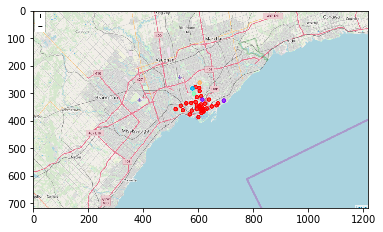

In [6]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('toronto_map.png')
imgplot = plt.imshow(img)
plt.show()